# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The main finding is that the doubling time of cumulative confirmed cases for countries with many cases is generally on the order of 2 days, which agrees with [this preprint](https://www.medrxiv.org/content/10.1101/2020.02.05.20020750v3.full.pdf) analyzing the growth of cases in provinces in China.

The notebook is updated every evening Eastern Time.

## Important Caveats:
- This analysis uses data on the confirmed cases as reported by countries, which is different from the actual number of cases in each country (many of which are not tested). 
- Confirmed cases and actual cases in the population grow at different rates. E.g. if a country suddenly ramps up testing, the number of confirmed cases will rapidly rise, but the actual cases may not be rising as fast.
- Since we're using the entire timeline to infer the doubling times, **these values are not typically the current or most recent doubling times**. For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as Mainland China), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the initial exponential stage of the epidemic (i.e., in the past).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/13/20


,3/13/20
Country/Region,
China,80945
Italy,17660
Iran,11364
"Korea, South",7979
Spain,5232
Germany,3675
France,3667
US,2179
Switzerland,1139


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            #print('\tThe number of confirmed cases rose from',lastweek,'on',co.index[-8],'to',current,'on',co.index[-1])
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time:',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.98:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.98:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 80945
	Confirmed cases on 3/6/20 	 80690
	Ratio: 1.0
	Weekly increase: 0.3 %
	Daily increase: 0.0 % per day
	Doubling Time: 1537.8 days

** Based on Logistic Fit**

	R^2: 0.994888762219
	Doubling Time:  3.23 (± 0.3 ) days


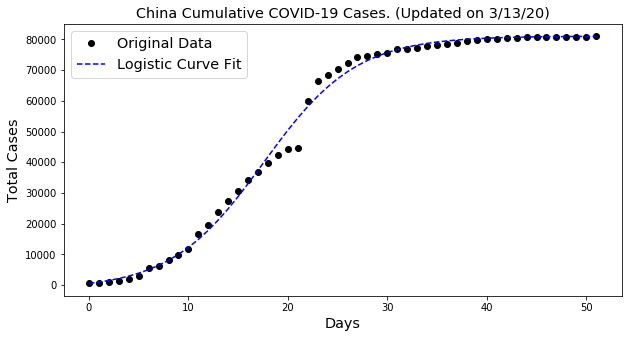



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 17660
	Confirmed cases on 3/6/20 	 4636
	Ratio: 3.81
	Weekly increase: 280.9 %
	Daily increase: 21.1 % per day
	Doubling Time: 3.6 days

** Based on Logistic Fit**

	R^2: 0.992837942237
	Doubling Time:  3.06 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.991280994582
	Doubling Time:  3.76 (± 0.23 ) days


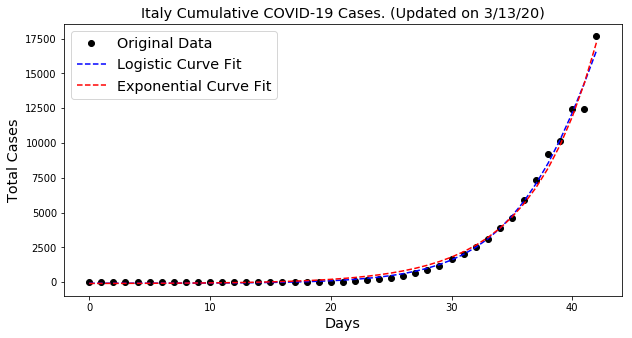



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 11364
	Confirmed cases on 3/6/20 	 4747
	Ratio: 2.39
	Weekly increase: 139.4 %
	Daily increase: 13.3 % per day
	Doubling Time: 5.6 days

** Based on Logistic Fit**

	R^2: 0.996109664681
	Doubling Time:  2.35 (± 0.36 ) days


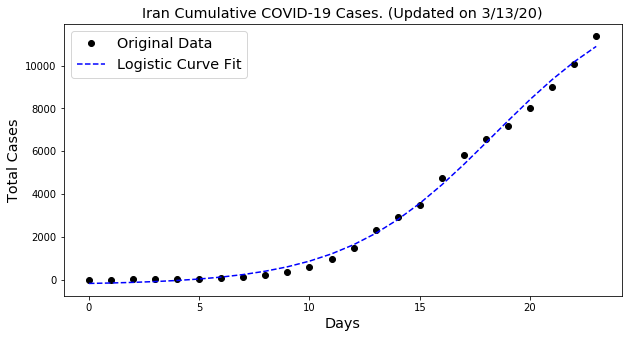



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 7979
	Confirmed cases on 3/6/20 	 6593
	Ratio: 1.21
	Weekly increase: 21.0 %
	Daily increase: 2.8 % per day
	Doubling Time: 25.4 days

** Based on Logistic Fit**

	R^2: 0.999591287605
	Doubling Time:  1.98 (± 0.05 ) days


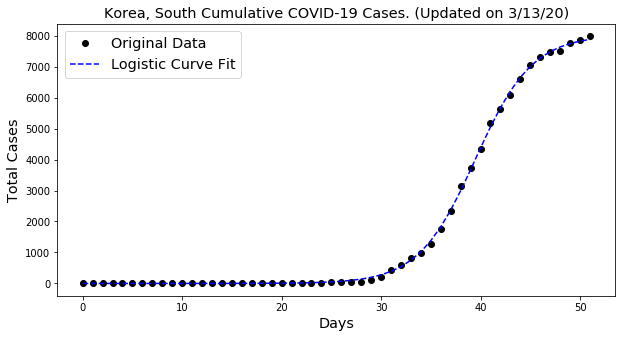



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 5232
	Confirmed cases on 3/6/20 	 400
	Ratio: 13.08
	Weekly increase: 1208.0 %
	Daily increase: 44.4 % per day
	Doubling Time: 1.9 days


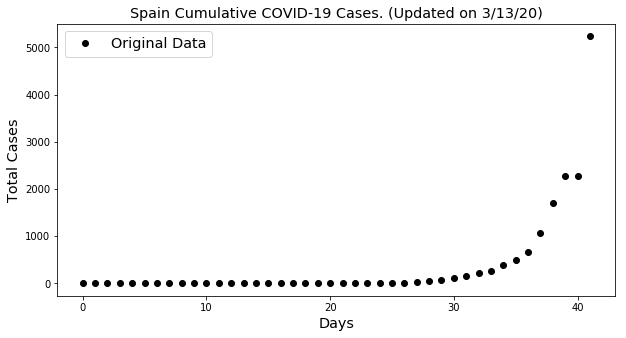



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 3675
	Confirmed cases on 3/6/20 	 670
	Ratio: 5.49
	Weekly increase: 448.5 %
	Daily increase: 27.5 % per day
	Doubling Time: 2.9 days

** Based on Exponential Fit **

	R^2: 0.981448451839
	Doubling Time:  2.58 (± 0.22 ) days


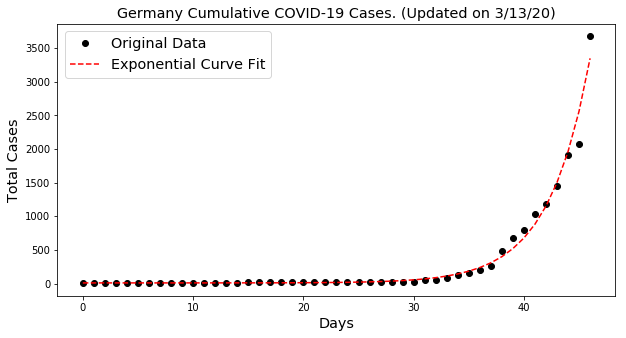



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 3667
	Confirmed cases on 3/6/20 	 656
	Ratio: 5.59
	Weekly increase: 459.0 %
	Daily increase: 27.9 % per day
	Doubling Time: 2.8 days

** Based on Exponential Fit **

	R^2: 0.986617796591
	Doubling Time:  2.79 (± 0.19 ) days


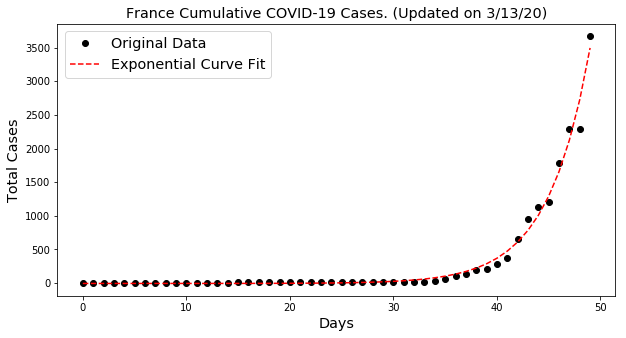



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 2179
	Confirmed cases on 3/6/20 	 262
	Ratio: 8.32
	Weekly increase: 731.7 %
	Daily increase: 35.3 % per day
	Doubling Time: 2.3 days

** Based on Exponential Fit **

	R^2: 0.997764260369
	Doubling Time:  2.35 (± 0.06 ) days


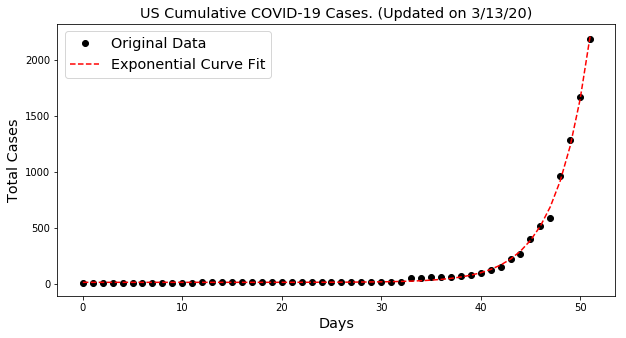



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 1139
	Confirmed cases on 3/6/20 	 214
	Ratio: 5.32
	Weekly increase: 432.2 %
	Daily increase: 27.0 % per day
	Doubling Time: 2.9 days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


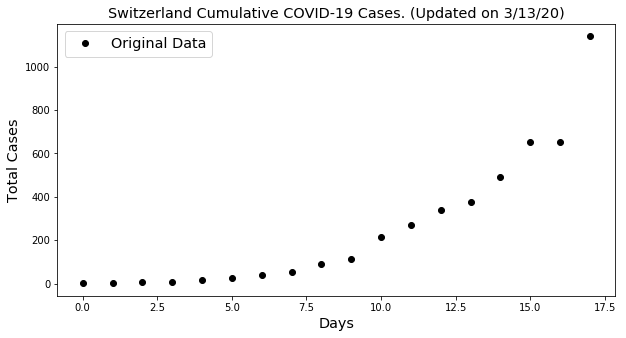



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 996
	Confirmed cases on 3/6/20 	 108
	Ratio: 9.22
	Weekly increase: 822.2 %
	Daily increase: 37.4 % per day
	Doubling Time: 2.2 days

** Based on Logistic Fit**

	R^2: 0.991954556683
	Doubling Time:  1.77 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.991315538252
	Doubling Time:  2.17 (± 0.25 ) days


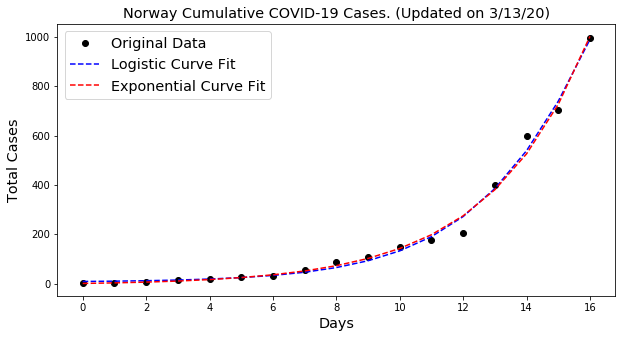



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 814
	Confirmed cases on 3/6/20 	 101
	Ratio: 8.06
	Weekly increase: 705.9 %
	Daily increase: 34.7 % per day
	Doubling Time: 2.3 days

** Based on Exponential Fit **

	R^2: 0.996602600835
	Doubling Time:  2.43 (± 0.09 ) days


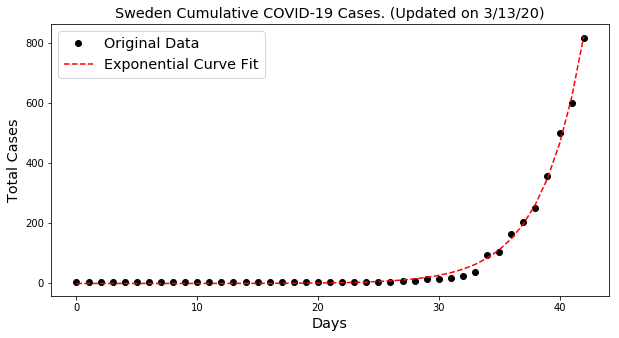



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 804
	Confirmed cases on 3/6/20 	 24
	Ratio: 33.5
	Weekly increase: 3250.0 %
	Daily increase: 65.1 % per day
	Doubling Time: 1.4 days

** Based on Logistic Fit**

	R^2: 0.997578456874
	Doubling Time:  0.76 (± 0.11 ) days


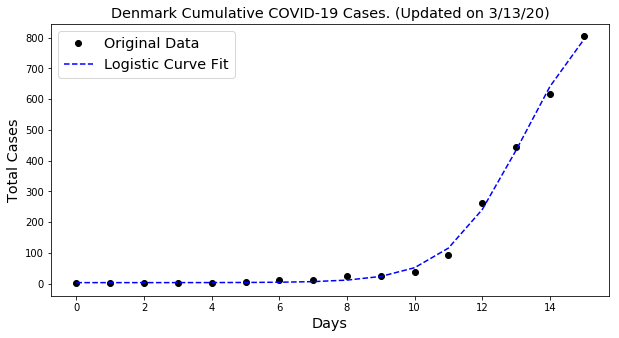



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 804
	Confirmed cases on 3/6/20 	 128
	Ratio: 6.28
	Weekly increase: 528.1 %
	Daily increase: 30.0 % per day
	Doubling Time: 2.6 days

** Based on Logistic Fit**

	R^2: 0.980069391975
	Doubling Time:  3.27 (± 3.42 ) days

** Based on Exponential Fit **

	R^2: 0.980069393728
	Doubling Time:  3.27 (± 0.74 ) days


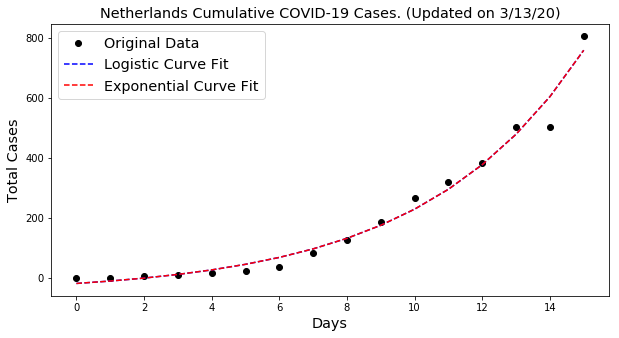



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 801
	Confirmed cases on 3/6/20 	 164
	Ratio: 4.88
	Weekly increase: 388.4 %
	Daily increase: 25.4 % per day
	Doubling Time: 3.1 days


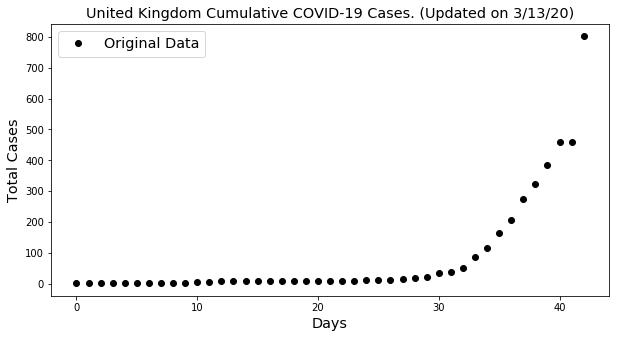



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 701
	Confirmed cases on 3/6/20 	 420
	Ratio: 1.67
	Weekly increase: 66.9 %
	Daily increase: 7.6 % per day
	Doubling Time: 9.5 days

** Based on Logistic Fit**

	R^2: 0.996750996109
	Doubling Time:  6.2 (± 0.7 ) days

** Based on Exponential Fit **

	R^2: 0.995218931118
	Doubling Time:  8.35 (± 0.41 ) days


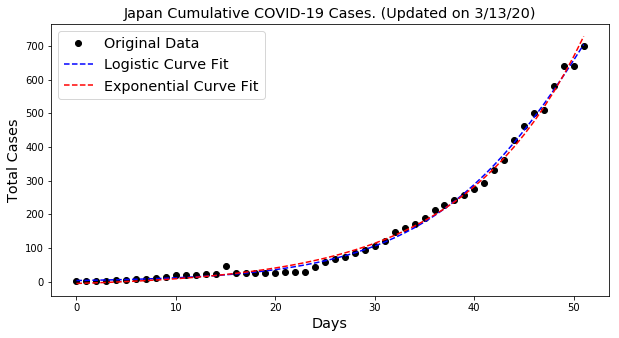



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995510032851
	Doubling Time:  1.35 (± 0.15 ) days


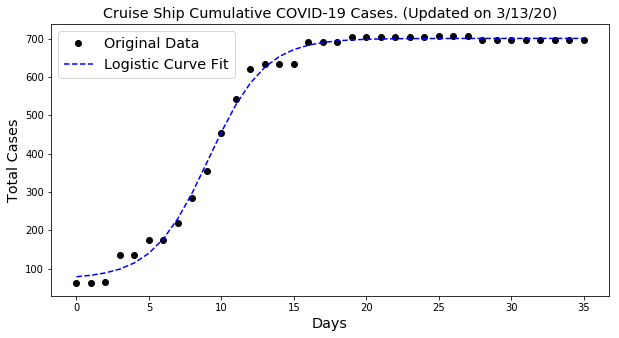



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 559
	Confirmed cases on 3/6/20 	 109
	Ratio: 5.13
	Weekly increase: 412.8 %
	Daily increase: 26.3 % per day
	Doubling Time: 3.0 days


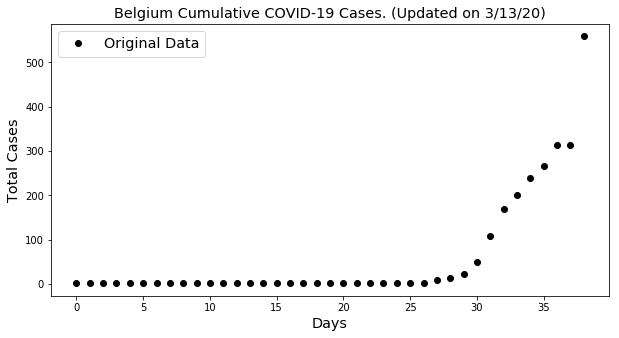



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 504
	Confirmed cases on 3/6/20 	 55
	Ratio: 9.16
	Weekly increase: 816.4 %
	Daily increase: 37.2 % per day
	Doubling Time: 2.2 days

** Based on Logistic Fit**

	R^2: 0.991055391987
	Doubling Time:  2.06 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.991055392287
	Doubling Time:  2.06 (± 0.23 ) days


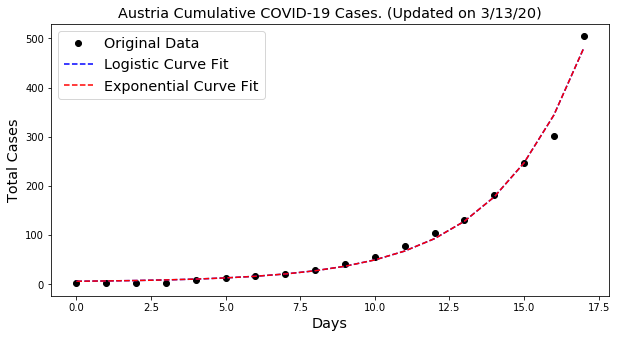



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 320
	Confirmed cases on 3/6/20 	 8
	Ratio: 40.0
	Weekly increase: 3900.0 %
	Daily increase: 69.4 % per day
	Doubling Time: 1.3 days

** Based on Logistic Fit**

	R^2: 0.98918671809
	Doubling Time:  0.14 (± 0.06 ) days


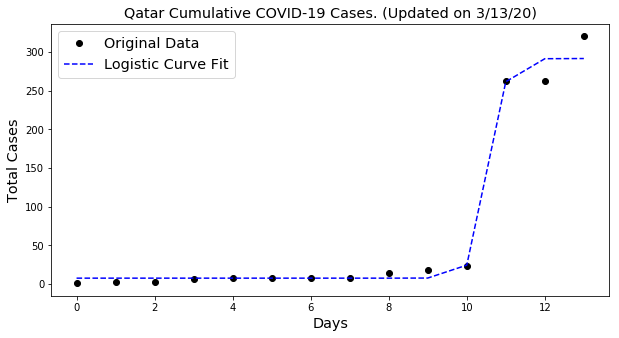



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 200
	Confirmed cases on 3/6/20 	 60
	Ratio: 3.33
	Weekly increase: 233.3 %
	Daily increase: 18.8 % per day
	Doubling Time: 4.0 days


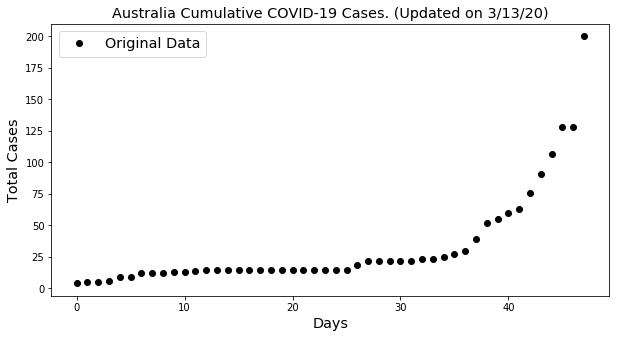



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 200
	Confirmed cases on 3/6/20 	 130
	Ratio: 1.54
	Weekly increase: 53.8 %
	Daily increase: 6.3 % per day
	Doubling Time: 11.3 days


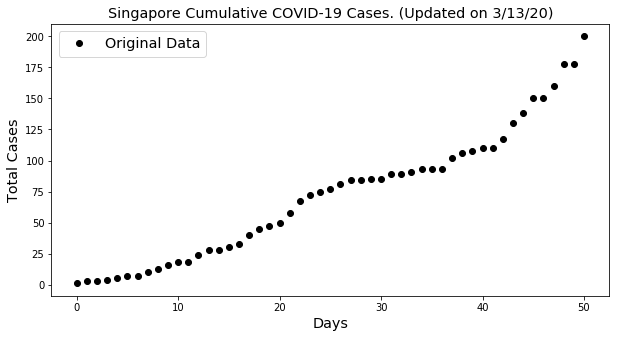



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 197
	Confirmed cases on 3/6/20 	 83
	Ratio: 2.37
	Weekly increase: 137.3 %
	Daily increase: 13.1 % per day
	Doubling Time: 5.6 days


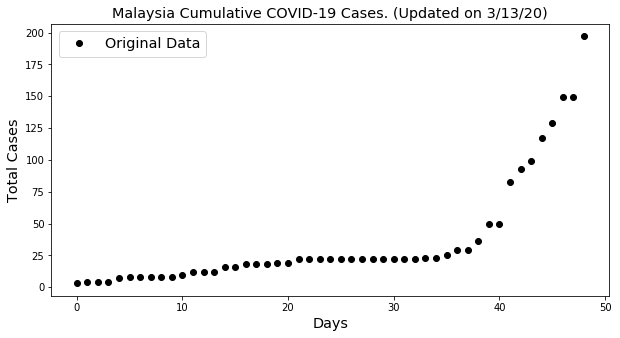



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 193
	Confirmed cases on 3/6/20 	 49
	Ratio: 3.94
	Weekly increase: 293.9 %
	Daily increase: 21.6 % per day
	Doubling Time: 3.5 days


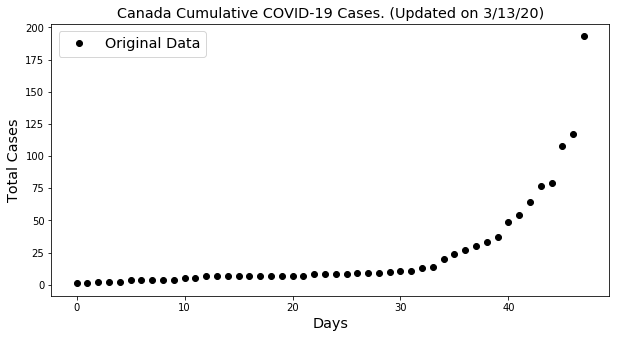



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 190
	Confirmed cases on 3/6/20 	 45
	Ratio: 4.22
	Weekly increase: 322.2 %
	Daily increase: 22.8 % per day
	Doubling Time: 3.4 days


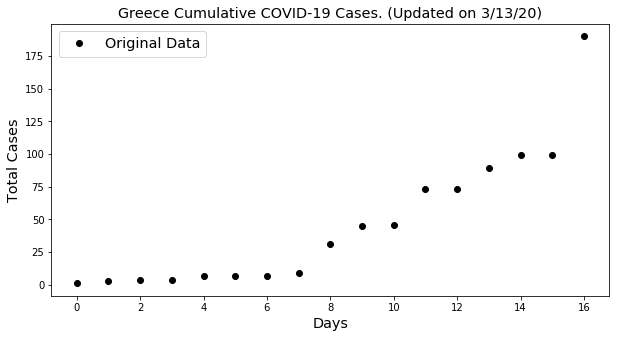



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 189
	Confirmed cases on 3/6/20 	 60
	Ratio: 3.15
	Weekly increase: 215.0 %
	Daily increase: 17.8 % per day
	Doubling Time: 4.2 days


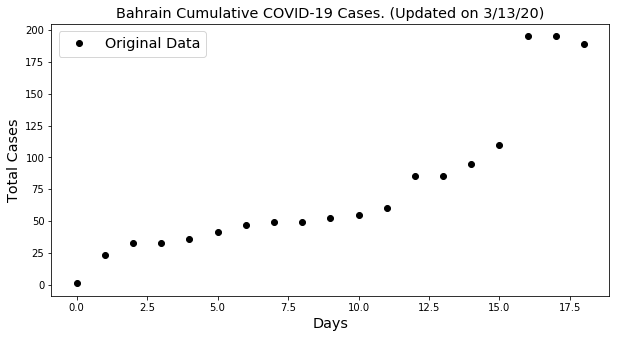



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 161
	Confirmed cases on 3/6/20 	 37
	Ratio: 4.35
	Weekly increase: 335.1 %
	Daily increase: 23.4 % per day
	Doubling Time: 3.3 days

** Based on Logistic Fit**

	R^2: 0.995795179265
	Doubling Time:  2.54 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.994939651201
	Doubling Time:  3.16 (± 0.25 ) days


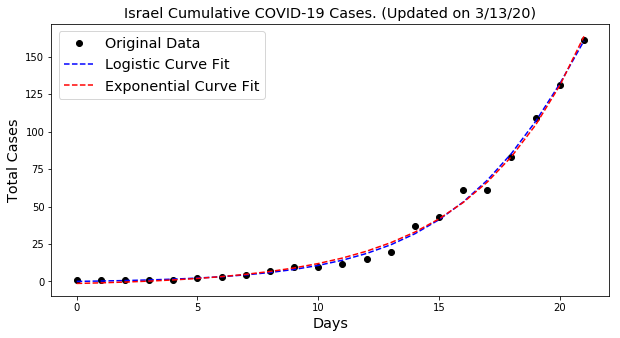



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 155
	Confirmed cases on 3/6/20 	 15
	Ratio: 10.33
	Weekly increase: 933.3 %
	Daily increase: 39.6 % per day
	Doubling Time: 2.1 days


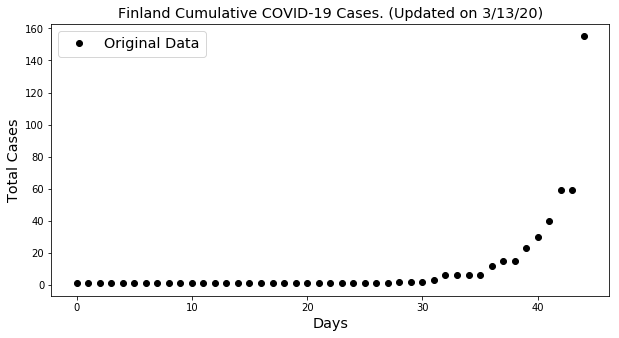



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 151
	Confirmed cases on 3/6/20 	 13
	Ratio: 11.62
	Weekly increase: 1061.5 %
	Daily increase: 42.0 % per day
	Doubling Time: 2.0 days


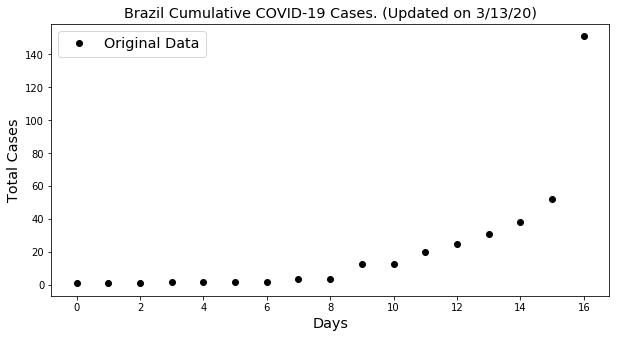



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 141
	Confirmed cases on 3/6/20 	 7
	Ratio: 20.14
	Weekly increase: 1914.3 %
	Daily increase: 53.6 % per day
	Doubling Time: 1.6 days

** Based on Logistic Fit**

	R^2: 0.997497231021
	Doubling Time:  1.14 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.996891107032
	Doubling Time:  1.45 (± 0.17 ) days


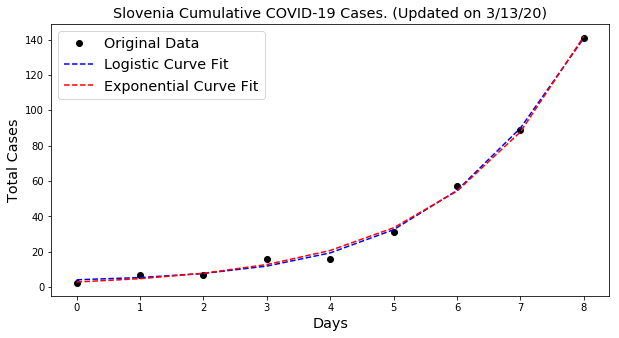



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 141
	Confirmed cases on 3/6/20 	 18
	Ratio: 7.83
	Weekly increase: 683.3 %
	Daily increase: 34.2 % per day
	Doubling Time: 2.4 days


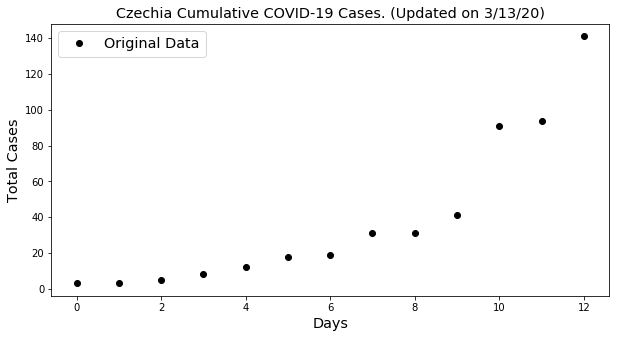



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 134
	Confirmed cases on 3/6/20 	 43
	Ratio: 3.12
	Weekly increase: 211.6 %
	Daily increase: 17.6 % per day
	Doubling Time: 4.3 days

** Based on Logistic Fit**

	R^2: 0.980270844326
	Doubling Time:  4.97 (± 3.51 ) days

** Based on Exponential Fit **

	R^2: 0.980270845268
	Doubling Time:  4.97 (± 1.65 ) days


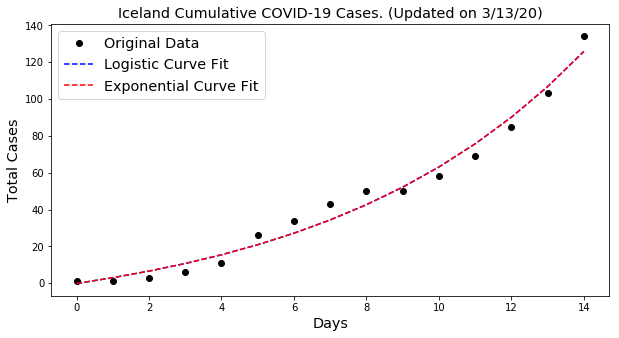



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 112
	Confirmed cases on 3/6/20 	 13
	Ratio: 8.62
	Weekly increase: 761.5 %
	Daily increase: 36.0 % per day
	Doubling Time: 2.3 days


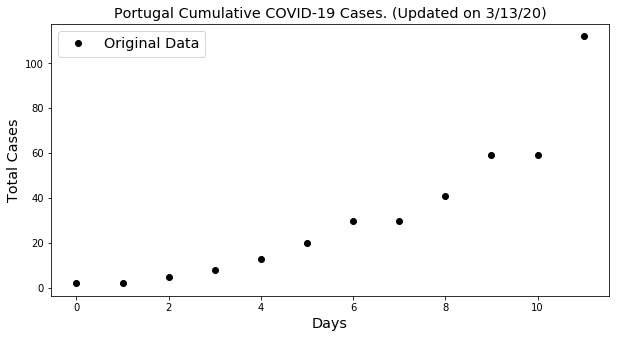



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 101
	Confirmed cases on 3/6/20 	 40
	Ratio: 2.52
	Weekly increase: 152.5 %
	Daily increase: 14.1 % per day
	Doubling Time: 5.2 days


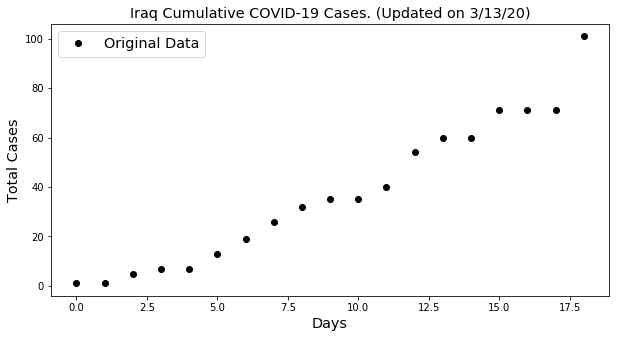

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are directly calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     3.2                1537.8
1            Italy                     3.1                   3.6
2             Iran                     2.4                   5.6
3     Korea, South                     2.0                  25.4
4            Spain                     NaN                   1.9
5          Germany                     2.6                   2.9
6           France                     2.8                   2.8
7               US                     2.3                   2.3
8      Switzerland                     NaN                   2.9
9           Norway                     1.8                   2.2
10          Sweden                     2.4                   2.3
11 

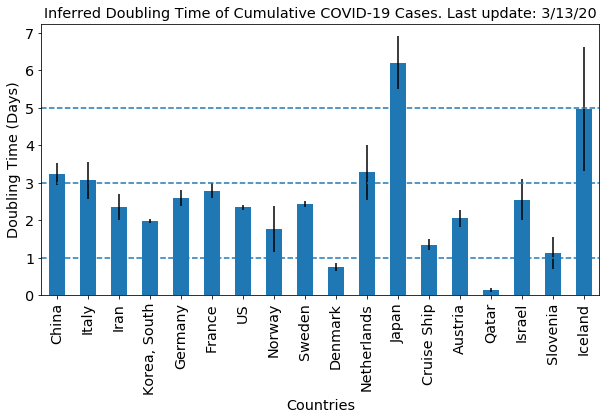

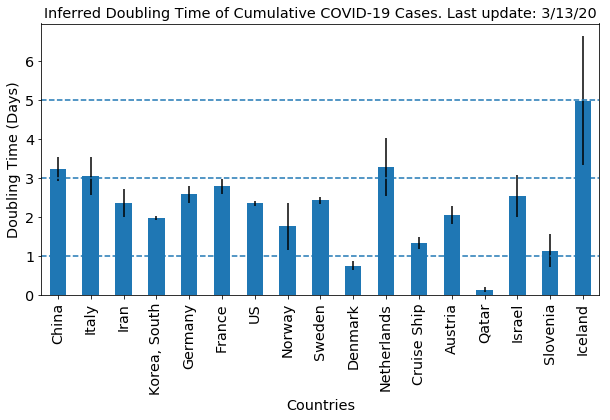

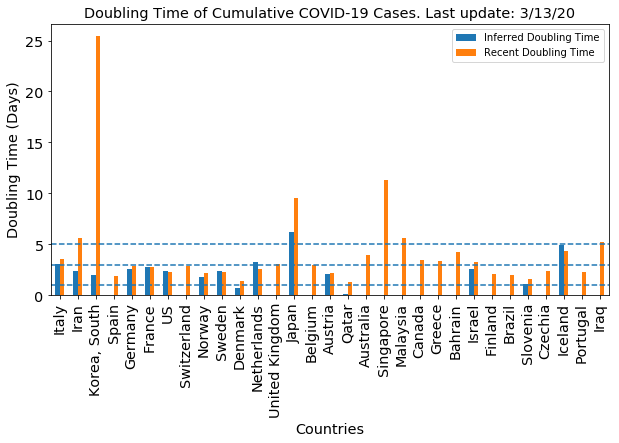

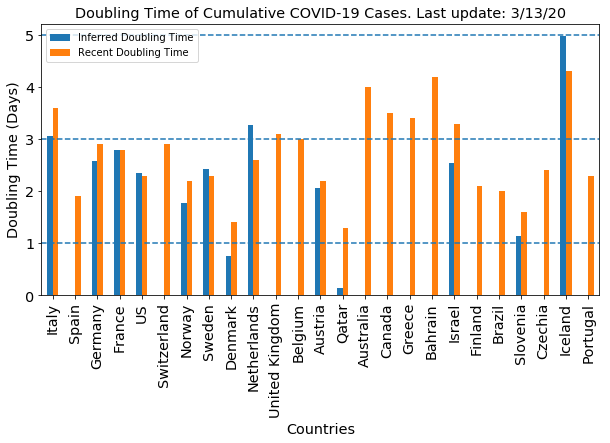

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are directly calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 30]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 30]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 5]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    if ',' in location:
        result = [x.strip() for x in location.split(',')]
        statename = states[result[1]]
        row['State'] = statename
        uscases.loc[index, 'Province/State'] = statename

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/13/20


,3/13/20
Province/State,
Washington,568
New York,421
California,282
Massachusetts,123
Florida,50
Colorado,49
Illinois,46
Diamond Princess,46
Texas,43


## Curve Fitting US COVID-19 Cases

                3/13/20
Province/State         
Washington          568
New York            421
California          282
Massachusetts       123


US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 568
	Confirmed cases on 3/6/20 	 78
	Ratio: 7.28
	Weekly increase: 628.2 %
	Daily increase: 32.8 % per day
	Doubling Time: 2.4 days

** Based on Exponential Fit **

	R^2: 0.990109150822
	Doubling Time:  2.35 (± 0.14 ) days


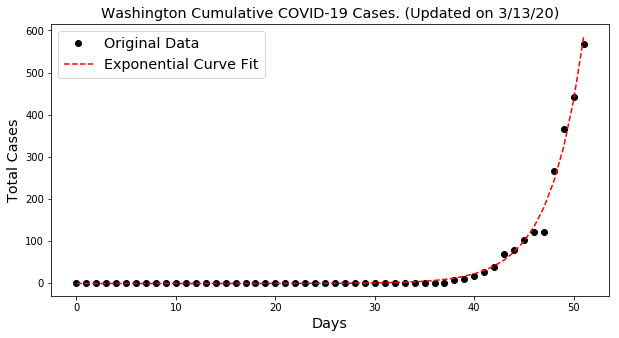



US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 421
	Confirmed cases on 3/6/20 	 31
	Ratio: 13.58
	Weekly increase: 1258.1 %
	Daily increase: 45.2 % per day
	Doubling Time: 1.9 days

** Based on Logistic Fit**

	R^2: 0.994754444512
	Doubling Time:  2.71 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.994754444737
	Doubling Time:  2.71 (± 0.4 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


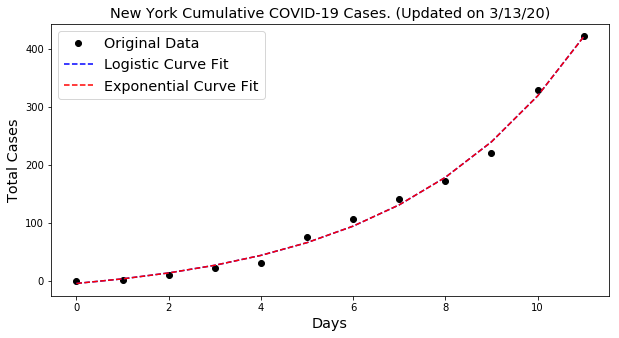



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 282
	Confirmed cases on 3/6/20 	 59
	Ratio: 4.78
	Weekly increase: 378.0 %
	Daily increase: 25.0 % per day
	Doubling Time: 3.1 days

** Based on Exponential Fit **

	R^2: 0.996375719639
	Doubling Time:  2.9 (± 0.11 ) days


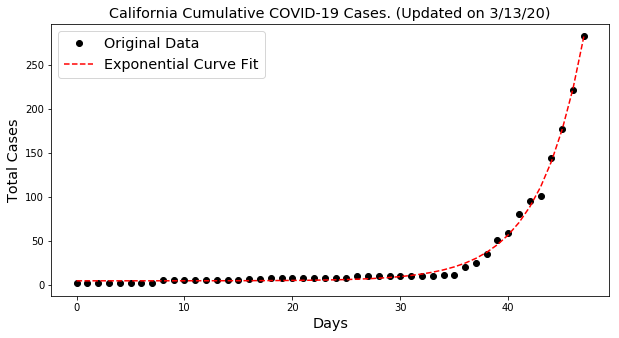



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 123
	Confirmed cases on 3/6/20 	 6
	Ratio: 20.5
	Weekly increase: 1950.0 %
	Daily increase: 54.0 % per day
	Doubling Time: 1.6 days


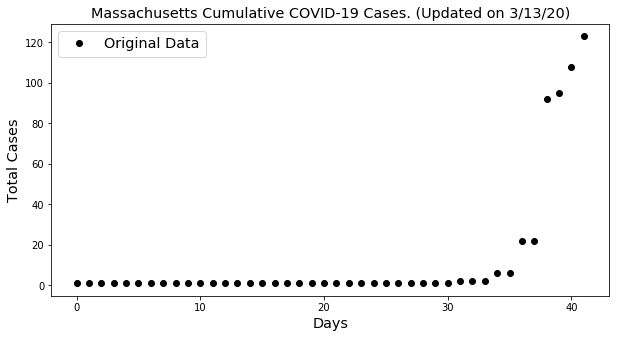

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are directly calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


          States  Inferred Doubling Time  Recent Doubling Time
0     Washington                     2.4                   2.4
1       New York                     2.7                   1.9
2     California                     2.9                   3.1
3  Massachusetts                     NaN                   1.6




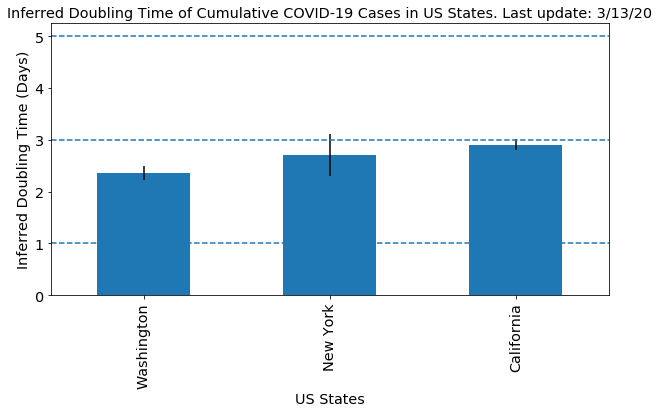

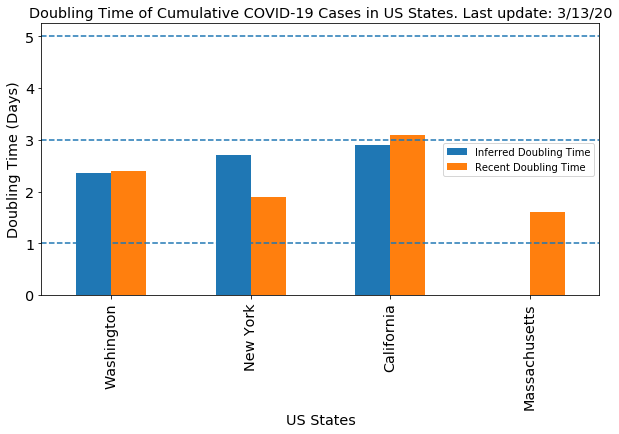

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are directly calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 30]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()


print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 30]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()